<a href="https://colab.research.google.com/github/MUKESHRAJMAHENDRAN/Deep-Learning--fastai/blob/main/05_pet_breeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 35.3 MB/s 
     |████████████████████████████████| 197 kB 56.8 MB/s 
     |████████████████████████████████| 1.2 MB 60.8 MB/s 
     |████████████████████████████████| 342 kB 74.0 MB/s 
     |████████████████████████████████| 4.2 MB 58.3 MB/s 
     |████████████████████████████████| 59 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 7.1 MB/s 
     |████████████████████████████████| 212 kB 70.1 MB/s 
     |████████████████████████████████| 136 kB 59.4 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 127 kB 72.7 MB/s 
     |████████████████████████████████| 271 kB 59.1 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 144 kB 68.3 MB/s 
     |████████████████████████████████| 6.6 MB 52.5 MB/s 
     |████████████████████████████████| 596 kB 53.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the p

In [2]:
#hide
from fastbook import *

# Image Classification

## From Dogs and Cats to Pet Breeds

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [6]:
(path/"images").ls()

(#7393) [Path('images/pug_34.jpg'),Path('images/Sphynx_124.jpg'),Path('images/Sphynx_58.jpg'),Path('images/havanese_191.jpg'),Path('images/Bombay_6.jpg'),Path('images/pomeranian_149.jpg'),Path('images/Egyptian_Mau_181.jpg'),Path('images/Birman_177.jpg'),Path('images/samoyed_155.jpg'),Path('images/saint_bernard_59.jpg')...]

In [7]:
fname = (path/"images").ls()[0]

In [8]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['pug']

In [9]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

## Presizing

### Checking and Debugging a DataBlock

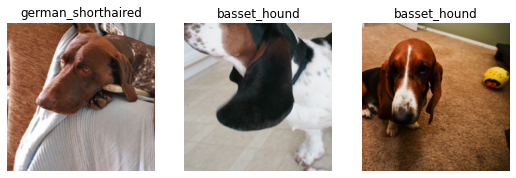

In [11]:
dls.show_batch(nrows=1, ncols=3)

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

## Cross-Entropy Loss

### Viewing Activations and Labels

In [ ]:
x,y = dls.one_batch()

In [ ]:
y

In [ ]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

In [ ]:
len(preds[0]),preds[0].sum()

### Softmax

In [ ]:
plot_function(torch.sigmoid, min=-4,max=4)

In [ ]:
#hide
torch.random.manual_seed(42);

In [ ]:
acts = torch.randn((6,2))*2
acts

In [ ]:
acts.sigmoid()

In [ ]:
(acts[:,0]-acts[:,1]).sigmoid()

In [ ]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

### Log Likelihood

In [ ]:
targ = tensor([0,1,0,1,1,0])

In [ ]:
sm_acts

In [ ]:
idx = range(6)
sm_acts[idx, targ]

In [ ]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['result'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

In [ ]:
-sm_acts[idx, targ]

In [ ]:
F.nll_loss(sm_acts, targ, reduction='none')

#### Taking the Log

Recall that cross entropy loss may involve the multiplication of many numbers.  Multiplying lots of negative numbers together can cause problems like [numerical underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow) in computers.  Therefore, we want to transform these probabilities to larger values so we can perform mathematical operations on them.  There is a mathematical function that does exactly this: the *logarithm* (available as `torch.log`). It is not defined for numbers less than 0, and looks like this between 0 and 1:

In [ ]:
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

In [ ]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='- log(x)', title = 'Log Loss when true label = 1')

In [ ]:
from IPython.display import HTML
df['loss'] = -torch.log(tensor(df['result']))
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

### Negative Log Likelihood

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
loss_func(acts, targ)

In [ ]:
F.cross_entropy(acts, targ)

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

## Model Interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

## Improving Our Model

### The Learning Rate Finder

In [16]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.664156,5.822745,0.509472,01:14


epoch,train_loss,valid_loss,error_rate,time
0,3.762541,2.335304,0.657645,01:17


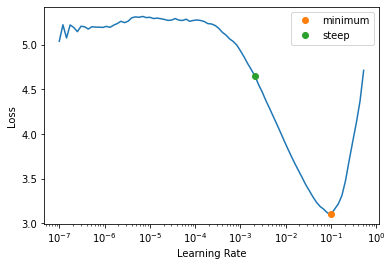

In [17]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [18]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 2.09e-03


In [21]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.334879,0.371053,0.119756,01:22


epoch,train_loss,valid_loss,error_rate,time
0,0.547440,0.392177,0.119080,01:18
1,0.341453,0.288694,0.085927,01:17


### Unfreezing and Transfer Learning

In [22]:
#learn.fine_tune??

In [23]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.156467,0.377496,0.116373,01:11
1,0.520440,0.294080,0.084574,01:11
2,0.314360,0.258578,0.077131,01:11


In [24]:
learn.unfreeze()

SuggestedLRs(valley=2.511886486900039e-05)

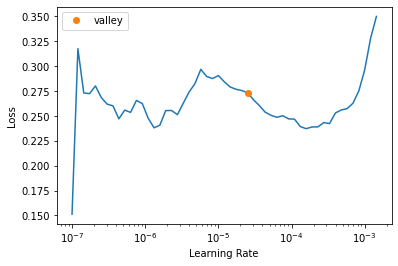

In [25]:
learn.lr_find()

In [26]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.256544,0.259017,0.076455,01:17
1,0.228519,0.246978,0.074425,01:17
2,0.214960,0.240534,0.071042,01:18
3,0.201456,0.237532,0.071042,01:17
4,0.176188,0.235368,0.073072,01:17
5,0.180512,0.238139,0.071719,01:17


### Discriminative Learning Rates

In [27]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(8, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.136785,0.380223,0.110284,01:11
1,0.523489,0.310369,0.095399,01:11
2,0.329098,0.261912,0.078484,01:11


epoch,train_loss,valid_loss,error_rate,time
0,0.261475,0.255393,0.076455,01:17
1,0.244022,0.251076,0.079161,01:17
2,0.216754,0.241401,0.074425,01:17
3,0.211632,0.245860,0.070365,01:16
4,0.190057,0.240090,0.071042,01:16
5,0.172886,0.246063,0.071042,01:16
6,0.147288,0.243775,0.074425,01:16
7,0.158478,0.241310,0.066306,01:16


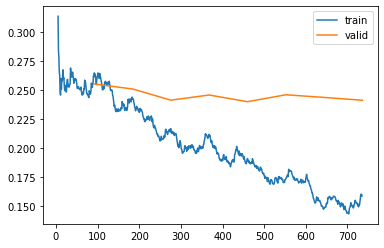

In [28]:
learn.recorder.plot_loss()

### Selecting the Number of Epochs

### Deeper Architectures

In [29]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.302042,0.320924,0.100135,01:08
1,0.596784,0.282380,0.098782,01:08
2,0.408727,0.304738,0.092693,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.288165,0.268172,0.079161,01:09
1,0.313125,0.380513,0.109608,01:09
2,0.245671,0.310210,0.091340,01:10
3,0.170365,0.270297,0.073748,01:09
4,0.100788,0.235597,0.059540,01:09
5,0.063954,0.226725,0.058187,01:10
